In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, mannwhitneyu, levene, shapiro

from tqdm.auto import tqdm
import statsmodels.api as sm

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

# Задача:

#### 1. Сравните результат между тестом и контролем по двум кейсам:
    Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value.
    Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value.
#### 2. Напишите выводы, которые можно сделать на основе анализа примененных критериев

In [3]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv', sep=';')

#### Описание колонок:
    1. value – значения метрики
    2. experimentVariant – Вариант теста (Control – контроль, Treatment – тест)

In [4]:
df.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [5]:
df.tail()

,Unnamed: 0,value,experimentVariant
995,996,1000,Treatment
996,997,1200,Treatment
997,998,1500,Treatment
998,999,2000,Treatment
999,1000,3000,Treatment


In [6]:
print(f'Количесвто строк: {df.shape[0]}, количество колонок: {df.shape[1]}')

Количесвто строк: 1000, количество колонок: 3


In [7]:
df = df \
    .drop(columns=('Unnamed: 0')) \
    .rename(columns=({'experimentVariant':'experiment_variant'}))

In [8]:
df.head()

,value,experiment_variant
0,"10,3804953740268",Control
1,"9,54686666784264",Control
2,"11,0882146509904",Control
3,"10,1472740570122",Control
4,"9,78980767524929",Control


In [9]:
# Узнаем количество наблюдений в каждой из выборок для бутстрапа.

In [10]:
df.experiment_variant.value_counts()

Treatment    500
Control      500
Name: experiment_variant, dtype: int64

In [11]:
df.value.value_counts()

9,56231578613995    2
11,9238041547632    2
9,42460667083465    2
9,41405109398747    2
10,8703330830034    2
                   ..
11,4995664874117    1
1200                1
1500                1
3000                1
8,78009049875068    1
Name: value, Length: 505, dtype: int64

In [12]:
# Видим, что колонка value представлена в виде строки, хотя внутри значения численные.
# Также, целая и дроьная часть разделены запятой, а не точкой, что не позволит нам изменить формат на float.
df.dtypes

value                 object
experiment_variant    object
dtype: object

In [13]:
df.value = df.value.str.replace(',', '.').astype(float)

In [14]:
# создаем отфлильтрованный дата фрейм только со значениями Treatment

treatment_df = df.query('experiment_variant == "Treatment"').reset_index(drop='yes').value
treatment_df.head()

0    10.380495
1     9.546867
2    11.088215
3    10.147274
4     9.789808
Name: value, dtype: float64

In [15]:
# создаем отфлильтрованный дата фрейм только со значениями Control

control_df = df.query('experiment_variant == "Control"').value
control_df.head()

0    10.380495
1     9.546867
2    11.088215
3    10.147274
4     9.789808
Name: value, dtype: float64

In [16]:
# Мы видим, что среднее тестового распределения увеличилось, а медиана практически не изменились по сравнению с
# контролькной группой.

In [17]:
print(f'Среднее (Контрольная:{control_df.mean()} / Тестовая:{treatment_df.mean()})')

Среднее (Контрольная:10.026866533804297 / Тестовая:27.321499056661573)


In [18]:
print(f'Медиана (Контрольная:{control_df.median()} / Тестовая:{treatment_df.median()})')

Медиана (Контрольная:10.0184651909296 / Тестовая:10.02584684253515)


In [19]:
# Делаем разведывательный анализ распределений. Судя по тесту Левена, дисперсии распределений не гомогенны.
# Также мы видим ненормальность распределения тестовой выборки дальше на боксплоте и qq плоте.

# Для нашего задания это не критично, т.к. мы используем непараметрический u-критерий и bootstrap, однако это 
# не позволяет нам использовать параметрические методы.

levene(treatment_df, control_df)

LeveneResult(statistic=4.297836608151554, pvalue=0.03841703888538016)

In [35]:
# Судя по графикам ниже, распределение контрольной группы очень близко к нормальному, когда в тестовой группе 
# наблюдается сильная ассисметрия в левую сторону и наличие сильных выбросов. Поэтому распределние очень 
# далеко от нормального.

# Также тест Шапиро-Уилка показал нам что распределение контрольной группы близко к нормальному (p-value > 0.05, 
# при нулевой гипотезе - распределение нормально распределено), а у тестовой группы - наоборот.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


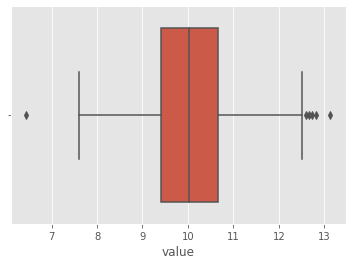

In [21]:
# Контрольная группа 

sns.boxplot(control_df)

In [34]:
shapiro(control_df)

ShapiroResult(statistic=0.9959248900413513, pvalue=0.22416365146636963)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


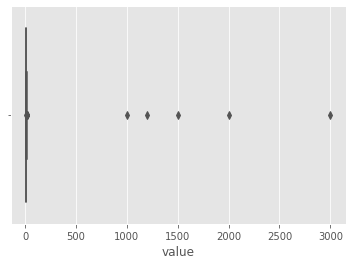

In [22]:
# Тестовая группа

sns.boxplot(treatment_df)

In [33]:
shapiro(treatment_df)

ShapiroResult(statistic=0.07038933038711548, pvalue=1.0930128021733573e-43)

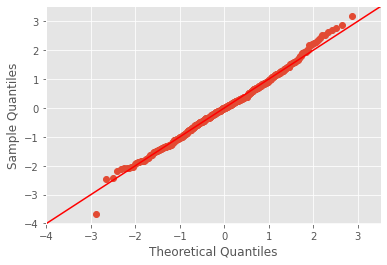

In [23]:
# Контрольная группа 

fig = sm.qqplot(control_df, fit=True, line="45")
plt.show()

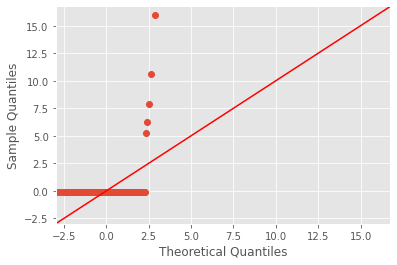

In [24]:
# Тестовая группа

fig = sm.qqplot(treatment_df, fit=True, line="45")
plt.show()

In [25]:
# Гипотезы:

# H0 - средние / медианы / средние рангов двух распределений не отличаются.
# H1 - средние / медианы / средние рангов распределений отличаются статистически значимо.

In [26]:
# P-value теста Манна-Уитни показывает значение выше 0.05 и не позволяет нам отклонить нулевую гипотезу, 
# что средние рангов двух распределений равны между собой. Результаты этого теста дейстительно можно считать 
# достоверными, но его результаты сложно интерпретировать, т.к. мы сравниваем ранги. 

In [27]:
mannwhitneyu(treatment_df, control_df)

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)

In [28]:
# Используя bootstrap по среднему мы видим, что доверительный интервал бут-страпированного распределения не 
# пересекает 0, при p-value < 0.05. Это значит, что в тесте мы получили статистически значимые отличия среднего и 
# теоретически можем отклонить нулевую гипотезу.

# Однако, т.к. распределение тестовой группы отлично от нормального и имеет выбросы, то использовать среднее для 
# оценки будет некорректным. В данном случае для оценки лучше подойдет медиана.

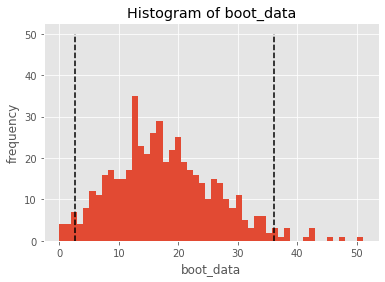

{'boot_data': [30.315230169486373,
  21.22231796863908,
  20.258276141171542,
  14.768221877547166,
  12.859492179806864,
  14.750340426217155,
  8.913170465092346,
  15.005277089903156,
  25.810021081084138,
  12.831824162112524,
  27.088176175847867,
  12.39709887147741,
  20.91162705082883,
  28.608614723964838,
  30.11802129084329,
  19.695406358388468,
  5.033061237677727,
  13.95395145934519,
  15.321637362689463,
  8.344787711981477,
  22.692271098089115,
  13.934203056486664,
  29.22381797802711,
  9.97564795938315,
  10.912009378152904,
  17.688051665974417,
  11.237557213088666,
  6.008909257110747,
  10.36196608874546,
  32.64447835392241,
  14.310358508239759,
  4.780807234867204,
  33.97466401932857,
  21.32836269209809,
  13.214465153920958,
  21.87418086804797,
  35.59238772936227,
  7.391541596584782,
  18.7289036497077,
  -0.01566627451457136,
  9.902375946233278,
  8.588131052662083,
  26.24395185289767,
  14.193109279116296,
  12.43378285234936,
  11.021400371468138,

In [29]:
get_bootstrap(treatment_df, control_df, boot_it = 500, statistic=np.mean)

In [30]:
# В случае с медианой картина противоположная, мы не видим статистически значимых различий, что говорит о том,
# что медианы в тестовой и контрольной группах примерно равны. Также доверительный интервал находится на пересечении 0.
# Все это нам говорит о том, что мы не можем отклонить Н0, хотя мы и видели увеличение средних значений.

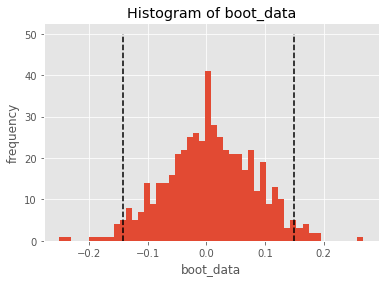

{'boot_data': [-0.06196229855684976,
  -0.025318246562820335,
  0.025804452558129576,
  -0.09881891811109966,
  -0.06734556266524994,
  -0.13562283270632491,
  0.10205374914556042,
  0.011235150676930594,
  0.03934767418308471,
  -0.03788334809039462,
  0.06647979843480023,
  -0.0026678276264160417,
  0.12422770016584916,
  -0.1255542846005051,
  -0.01293003068905918,
  -0.04042343404573945,
  -0.0754861436876153,
  0.08954165181633478,
  -0.0776323901139504,
  0.06300065462757942,
  0.08775471994959982,
  -0.00699213983619984,
  -0.04829467652002872,
  -0.11701235151519462,
  -0.007204662563546016,
  0.06623152464129589,
  -0.10774047551359,
  0.024113554649829894,
  0.04542494333660496,
  -0.015687963461799903,
  0.10532103031874929,
  0.04122310762814951,
  0.06256686280344947,
  0.09869637696320055,
  0.03313363822832471,
  -0.018826748304800134,
  0.045249162278524935,
  -0.05390726013270086,
  0.04967958422741514,
  0.03002191473179927,
  -0.028383501970400182,
  0.05793669802008

In [31]:
get_bootstrap(treatment_df, control_df, boot_it = 500, statistic=np.median)

# Вывод:

В данном случае, в тестовой группе мы наблюдаем сильные выбросы, что делает наше распеределение не нормальным, не позволяют нам использовать параметрические методы и сильно смещает среднее значение в бОльшую сторону. Это негативно влияет на результаты bootstrap по среднему значению. Однако при переводе значений в ранги, используя u-Мана Уитни, или используя bootstrap по медиане, мы сгладили эффект сильных выбросов и также получим близкий к реальности статистически значимый результат.

Поэтому в данном случае более правильно делать оценку на основе bootstrap по медиане. На второе место я бы поставил непараметрический тест Манна-Уитни, как более консервативный способ.

Проведенный bootstrap тест показал нам, что медианы в тестовой и контрольной группах статистически значимо равны (p-value > 0.05). Также доверительный интервал находится на пересечении 0. Прэтому мы не станем отклонять нулевую гипотезу.

Похожий результат дал тест Манна-Уитни, и мы такж не можем отклонить нулевую гипотезу.